In [90]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.special import gammaln, digamma
import itertools
from tqdm import tqdm

In [91]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
qp = np.random.random(3)
qp /= qp.sum()
qv = np.random.random(2)
qv /= qv.sum()
print("qv", qv)
print("qp", qp)

q = np.random.random((3, 2, 2))
q_sum = np.sum(q, axis=-1)
q = q / q_sum[..., np.newaxis]

rollout_t_index = 1
action = 1

qv [0.38652504 0.61347496]
qp [0.33702744 0.50830568 0.15466689]


In [117]:
new_qv = qp @ (qv @ q[ :, :, :])
print(new_qv)

[0.42304285 0.57695715]


In [118]:
x = np.outer(qp, qv)[..., None] * q[:, :, :]
new_qv = x.sum(axis=(0, 1))
new_qv

array([0.42304285, 0.57695715])

In [ ]:
for i, qp_i in enumerate(qp):
    for k, qv_k in enumerate(qv): 
                

In [111]:
a = np.sum(np.outer(qp, qv)[..., None] * q[rollout_t_index, action, :, :, :], axis=(0, 1))
a / a.sum()

array([0.54210037, 0.45789963])

In [112]:
a = np.sum(np.outer(qp, qv) @ q[rollout_t_index, action, :, :, :], axis=(0, 1))
a/= a.sum()
a

array([0.54680309, 0.45319691])

In [97]:
to_add = np.outer(qp, qv)[..., None] * q[rollout_t_index, a, :, :, :]
# to_add = np.expand_dims(np.outer(qp, qv), axis=-1) * q[rollout_t_index, a, :, :, :]
q[rollout_t_index, a, :, :, :] += to_add

print(to_add)

# to_add = np.outer(qp, qv) * q[rollout_t_index, a, :, :, :]

print("shape", to_add.shape)
print(to_add.sum(axis=(0, 1)).shape)
# Update beliefs about the velocity and position
# [IMPORTANT] => do it after updating beliefs about the transitions
qv = qp @ (qv @ q[rollout_t_index, a, :, :, :])

print(qv)

[[[0.25553525 0.0652936 ]
  [0.03409715 0.05810418]]

 [[0.00821827 0.09064177]
  [0.015215   0.01319587]]

 [[0.1930288  0.16405084]
  [0.00315275 0.0994665 ]]]
shape (3, 2, 2)
(2,)
[0.66486902 0.59518028]


# Modelling the 'true' ball force as a GP with a squared exponential kernel

We assume that the force of the ball is a Gaussian process with a squared exponential kernel. The kernel is defined as follows:
$$
k(x, x') = \alpha^2 \exp\left(-\frac{1}{2l^2} (x - x')^2\right)
$$
where $\alpha$ is the amplitude and $l$ is the length scale. We assume that the ball is pushed at the beginning of the game, and that the force is constant throughout the game. The force is sampled from a Gaussian process with the above kernel. The mean of the Gaussian process is a cosine function with a period of $2\pi/6$ and an amplitude of $0.5$. The mean is shifted by $5$ units to the right. The variance of the Gaussian process is $\sigma^2 = k(x, x)$. The following figure shows the mean and the variance of the Gaussian process.

    x1: 2D array of shape (m,n) representing the first dimension of the input grid
    x2: 2D array of shape (m,n) representing the second dimension of the input grid
    mu: 1D array of shape (m*n,) representing the mean function evaluated at the input grid
    sigma: 2D array of shape (m*n,m*n) representing the covariance matrix
    n_sample: int, number of samples to generate

In [3]:
def rbf(x, alpha=0.05, length=0.1):
    sqdist = np.sum(x**2, axis=1)[:, None] + np.sum(x**2, axis=1)[None, :] - 2 * np.dot(x, x.T)
    sigma = alpha**2 * np.exp(-0.5 * sqdist / length**2)
    return sigma

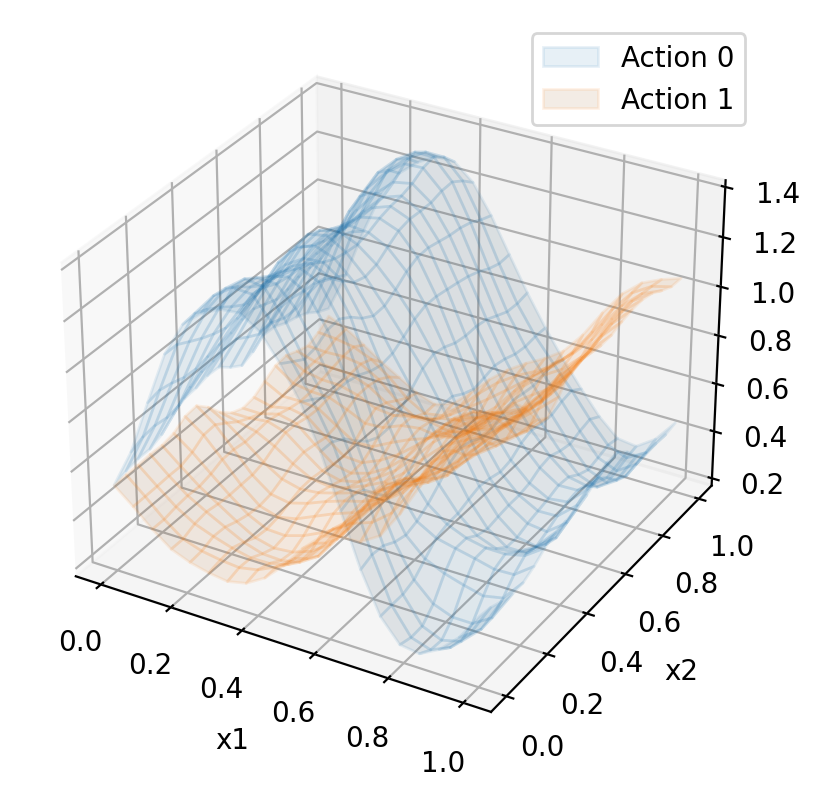

In [4]:
# Define the input grid
n_x1 = 20
n_x2 = 20
n_x = n_x1 * n_x2

x1 = np.linspace(0, 1.0, n_x1)
x2 = np.linspace(0, 1.0, n_x2)
x = np.column_stack([_x.ravel() for _x in np.meshgrid(x1, x2)])


# Define the covariance function
sigma = rbf(x)

n_dim = x.shape[-1]
n_sample = 1
y = np.zeros((n_dim, n_sample, n_x))

# Generate samples for while "not pushing" or "pushing" the ball (action '0' and '1') 
mu = np.zeros((2, n_x))
mu[0] = 0.8 + 0.5*np.cos(6*x[:,0] - 2) # + 0.3*np.sin(4*x[:,1] + 3)
mu[1] = 0.8 + 0.5*np.cos(3*x[:,0] - 4) # + 0.3*np.sin(4*x[:,1] + 3)
for i in range(2):
    y[i] = np.random.multivariate_normal(mu[i], sigma, n_sample)

# Plot the samples 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for y_idx in range(y.shape[0]):
    for sample in range(n_sample):
        surf = ax.plot_surface(
            *np.meshgrid(x1, x2), y[y_idx, sample].reshape(np.meshgrid(x1, x2)[0].shape), 
            label=f'Action {y_idx}', 
            rstride=1, cstride=1, alpha=0.1, 
            color=f"C{y_idx}", edgecolor=f"C{y_idx}")
        
        surf._edgecolors2d = surf._edgecolor3d
        surf._facecolors2d = surf._facecolor3d

ax.legend()

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')

plt.show()

# Moving to a discrete world

In [67]:
n_timestep = 6
n_velocity = 20
n_action = 2
n_position = 50

timestep = np.linspace(0, 1.0, n_timestep)
position = np.linspace(0, 2.0, n_position)
velocity = np.linspace(0., 3.0, n_velocity)
action = np.arange(n_action)

max_velocity = 10.0
friction_factor = 0.5

n_sample = 300

## Building the velocity transaction matrix

In [69]:
# Compute the 'true' transition probabilities for the velocity

#### Visualizing the velocity transition matrix

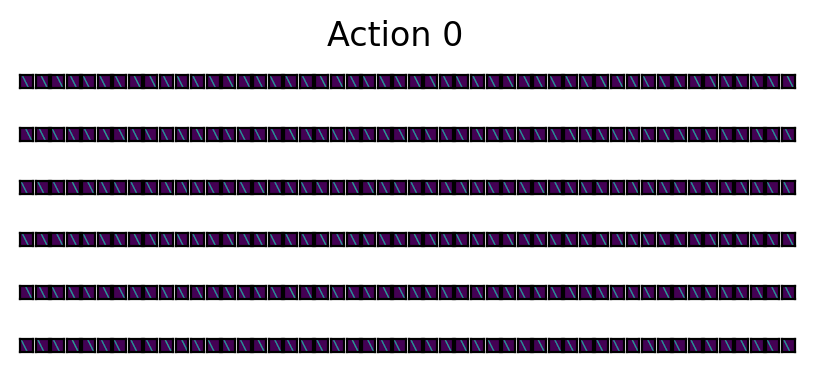

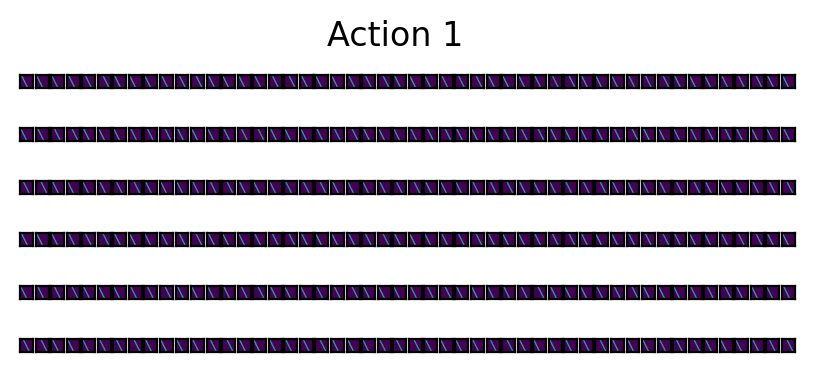

In [70]:
for a_idx in range(n_action):  
    fig, axes = plt.subplots(ncols=n_position, nrows=n_timestep, figsize=(5, 2))
    for i in range(n_action):
        for t_idx in range(n_timestep):
            for p_idx in range(n_position):
                ax = axes[t_idx, p_idx]
                img = transition_velocity_tapvv[t_idx, a_idx, p_idx, :, :]
                ax.imshow(img, aspect=1)
                ax.get_xaxis().set_ticks([])
                ax.axes.get_yaxis().set_ticks([])
                
    fig.suptitle(f"Action {a_idx}")
    plt.show()

## Computing the position transition matrix

In [71]:
from task.transition import compute_position_transition_matrix
transition_position_pvp = compute_position_transition_matrix(
    position=position, velocity=velocity, timestep=timestep, 
    transition_velocity_tapvv=transition_velocity_tapvv)

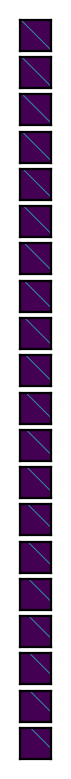

In [72]:
fig, axes = plt.subplots(nrows=n_velocity)
for i, ax in enumerate(axes):
    img = transition_position_pvp[:, i, :]
    ax.imshow(img, aspect=1)
    ax.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

# Running the environment

In [73]:
all_hist_pos = {}
all_hist_vel = {}

n_sample_run = 20

policies = ["all-one", "all-zero", "random", "max-expected-velocity"]
for policy in policies:

    hist_pos = np.zeros((n_sample_run, n_timestep))
    hist_vel = np.zeros_like(hist_pos)

    for sample in range(n_sample_run):

        p_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin()    # Something close to 0

        np.random.seed(123 + sample*123)

        for t_idx, t in enumerate(timestep):

            if policy == "all-one":
                a = 1
            elif policy == "all-zero":
                a = 0
            elif policy == "random":
                a = np.random.choice([0, 1])
            elif policy == "max-expected-velocity":
                e_v = np.zeros(2)
                for a in range(2):
                    e_v[a] = np.average(velocity, weights=transition_velocity_tapvv[t_idx, a, p_idx, v_idx, :])
                a = e_v.argmax()
            else:
                raise ValueError
            tr_vel = transition_velocity_tapvv[t_idx, a, p_idx, v_idx, :]
            # print(t_idx, a, p_idx, v_idx)
            v_idx = np.random.choice(np.arange(n_velocity), p=tr_vel)
            tr_pos = transition_position_pvp[p_idx, v_idx, :]
            p_idx = np.random.choice(np.arange(n_position), p=tr_pos)

            hist_pos[sample, t_idx] = position[p_idx]
            hist_vel[sample, t_idx] = velocity[v_idx]

        all_hist_pos[policy] = hist_pos
        all_hist_vel[policy] = hist_vel

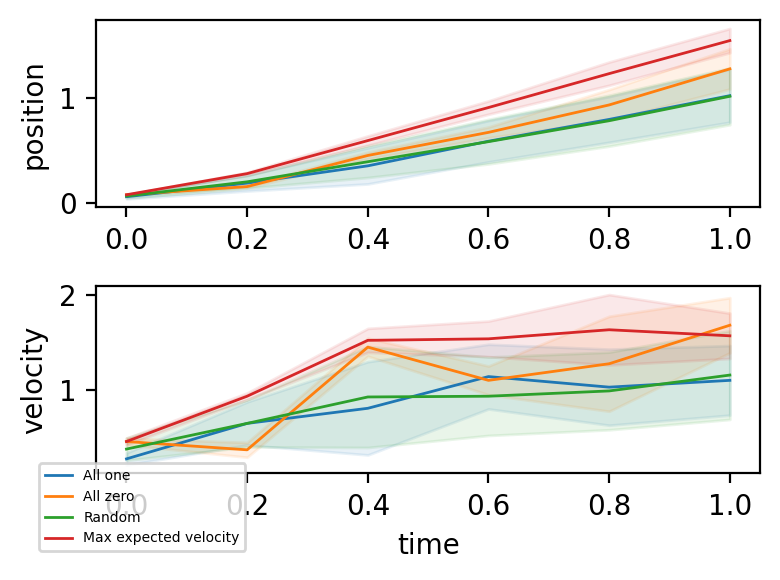

In [74]:
def plot_runs(policies, all_hist_pos, all_hist_vel):
    fig, axes = plt.subplots(nrows=2, figsize=(4, 3))
    for i, policy in enumerate(policies):
        label = policy.replace("-", " ").capitalize()
        pos = all_hist_pos[policy].mean(axis=0)
        pos_disp = all_hist_pos[policy].std(axis=0)
        vel = all_hist_vel[policy].mean(axis=0)
        vel_disp = all_hist_vel[policy].std(axis=0)
        x = np.linspace(0, 1, n_timestep)
        if label.startswith("Af"):
            label = label.replace("Af", "Active inference -")
            linewidth = 2
            if label.endswith("epistemic"):
                linestyle = ":"
                linewidth = 4
            elif label.endswith("pragmatic"):
                linestyle = "-."
            else:
                label = label.replace(" -", "")
                linestyle = "--"
        else:
            linestyle, linewidth = "-", 1
        axes[0].plot(x, pos, color=f"C{i}", label=label, linestyle=linestyle, linewidth=linewidth)
        axes[0].fill_between(x, pos - pos_disp, pos + pos_disp, alpha=0.1, color=f"C{i}")
        axes[1].plot(x, vel, color=f"C{i}", linestyle=linestyle, linewidth=linewidth)
        axes[1].fill_between(x, vel - vel_disp, vel + vel_disp, alpha=0.1, color=f"C{i}")
        axes[0].set_ylabel("position")
        axes[1].set_ylabel("velocity")
        axes[1].set_xlabel("time")

    fig.legend(loc=[0.05, 0.05], fontsize=5)
    fig.tight_layout()

plot_runs(policies, all_hist_pos, all_hist_vel)

## Preferences (biased prior on the position)

In [75]:
target = 1.0
tolerance = 0.5

# Compute log prior
p = norm.cdf(position, loc=target, scale=tolerance)
p /= p.sum()
log_prior = np.log(p)

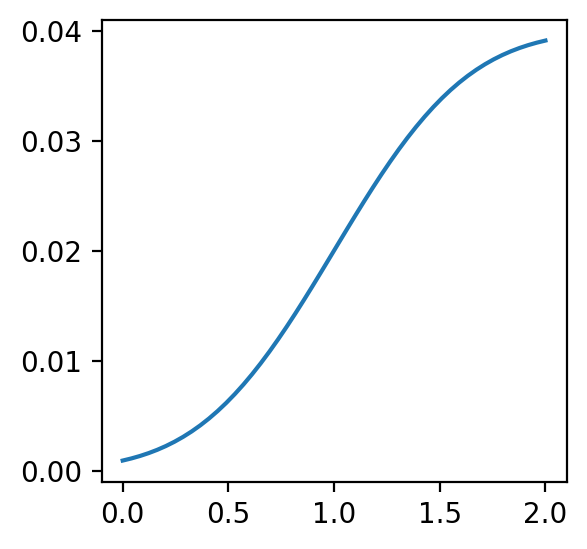

In [76]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(position, p);

## Helper functions

In [77]:
def kl_div_dirichlet(alpha_coeff, beta_coeff):
    """
        https://statproofbook.github.io/P/dir-kl.html
    """
    alpha_0 = np.sum(alpha_coeff)
    beta_0 = np.sum(beta_coeff)
    kl = (
        gammaln(alpha_0)
        - gammaln(beta_0)
        - np.sum(gammaln(alpha_coeff))
        + np.sum(gammaln(beta_coeff))
        + np.sum((alpha_coeff - beta_coeff) * (digamma(alpha_coeff) - digamma(alpha_0)))
    )
    return kl

# Pragmatic value focused

In [78]:
horizon = 6

# For logs
hist_pos, hist_vel = np.zeros((n_sample_run, n_timestep)), np.zeros((n_sample_run, n_timestep))

# For each sample...
for sample in range(n_sample_run):

    p_idx = np.absolute(position).argmin()  # Something close to 0
    v_idx = np.absolute(velocity).argmin() # Something close to 0

    np.random.seed(123 + sample*123)

    for t_idx in range(n_timestep):

        h = min(horizon, n_timestep - t_idx)
        action_plan = list(itertools.product(range(n_action), repeat=h))

        pragmatic = np.zeros(len(action_plan))
        for ap_index, ap in enumerate(action_plan):

            qvs = np.zeros((h, n_velocity))
            qps = np.zeros((h, n_position))

            qv = np.zeros(n_velocity)
            qv[v_idx] = 1.
            qp = np.zeros(n_position)
            qp[p_idx] = 1.

            for h_idx in range(h):
                a = ap[h_idx]
                qv = qp @ (qv @ transition_velocity_tapvv[t_idx + h_idx, a, :, :, :])
                qp = qp @ (qv @ transition_position_pvp)
                qvs[h_idx] = qv
                qps[h_idx] = qp

            pragmatic[ap_index] = np.sum(qps @ log_prior)

        a = action_plan[np.argmax(pragmatic)][0]

        v_idx = np.random.choice(np.arange(n_velocity), p=transition_velocity_tapvv[t_idx, a, p_idx, v_idx, :])
        p_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[p_idx, v_idx, :])

        hist_pos[sample, t_idx] = position[p_idx]
        hist_vel[sample, t_idx] = velocity[v_idx]

policy = "af-pragmatic"
if policy not in policies:
    policies.append(policy)
all_hist_pos[policy] = hist_pos
all_hist_vel[policy] = hist_vel


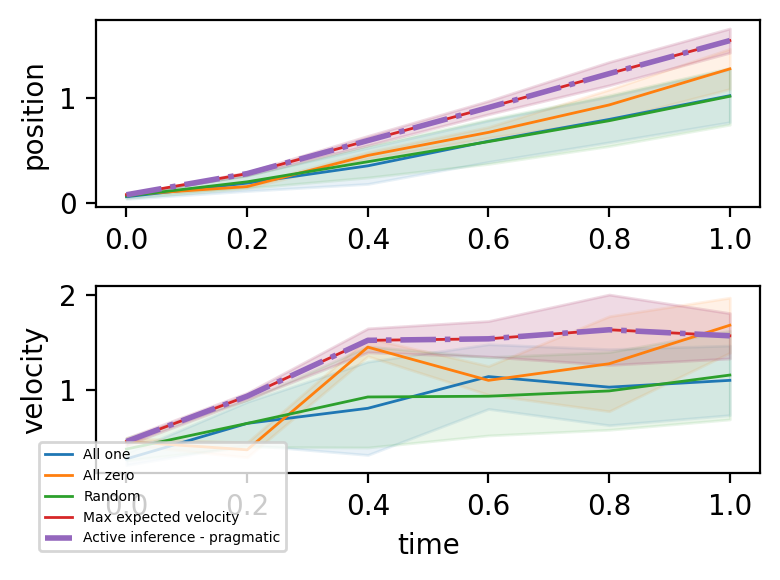

In [79]:
plot_runs(policies, all_hist_pos, all_hist_vel)

# Epistemic value

In [80]:
def q_transition_velocity(alpha):
    sum_col = np.sum(alpha, axis=-1)
    sum_col[sum_col <= 0.] = 1
    return alpha / np.expand_dims(sum_col, axis=-1)

In [81]:
all_hist_err = {}
policies_err = []

In [82]:
n_episode = 200
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))

for sample in range(n_sample_run):

    alpha_tapvv = np.zeros((n_timestep, n_action, n_position, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    if sample == 0:
        error = np.mean((
            transition_velocity_tapvv - q_transition_velocity(alpha_tapvv))**2)
        print(f"Initial error {error:.2f}")

    epoch = 0
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        p_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin() # Something close to 0

        action_plan = np.random.randint(n_action, size=n_timestep)

        for t_idx, t in enumerate(timestep):

            # Pick new action and draw new velocity
            a = action_plan[t_idx]
            tr_vel = transition_velocity_tapvv[t_idx, a, p_idx, v_idx, :]
            new_v_index = np.random.choice(np.arange(n_velocity), p=tr_vel)

            # Update alpha
            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_tapvv[t_idx, a, p_idx, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            tr_pos = transition_position_pvp[p_idx, v_idx, :]
            p_idx = np.random.choice(np.arange(n_position), p=tr_pos)

            # Log
            error = np.mean((transition_velocity_tapvv - q_transition_velocity(alpha_tapvv))**2)
            # print(error)
            hist_err[sample, epoch] = error
            epoch += 1

    print(f"[Sample {sample}] Error after {epoch} epochs {error:.6f}")

policy = "random"
if policy not in policies_err:
    policies_err.append(policy)
all_hist_err[policy] = hist_err

Initial error 0.03
[Sample 0] Error after 1200 epochs 0.029365
[Sample 1] Error after 1200 epochs 0.029368
[Sample 2] Error after 1200 epochs 0.029384
[Sample 3] Error after 1200 epochs 0.029391
[Sample 4] Error after 1200 epochs 0.029382
[Sample 5] Error after 1200 epochs 0.029416
[Sample 6] Error after 1200 epochs 0.029417
[Sample 7] Error after 1200 epochs 0.029386
[Sample 8] Error after 1200 epochs 0.029368
[Sample 9] Error after 1200 epochs 0.029367
[Sample 10] Error after 1200 epochs 0.029386
[Sample 11] Error after 1200 epochs 0.029400
[Sample 12] Error after 1200 epochs 0.029331
[Sample 13] Error after 1200 epochs 0.029381
[Sample 14] Error after 1200 epochs 0.029358
[Sample 15] Error after 1200 epochs 0.029358
[Sample 16] Error after 1200 epochs 0.029412
[Sample 17] Error after 1200 epochs 0.029386
[Sample 18] Error after 1200 epochs 0.029343
[Sample 19] Error after 1200 epochs 0.029384


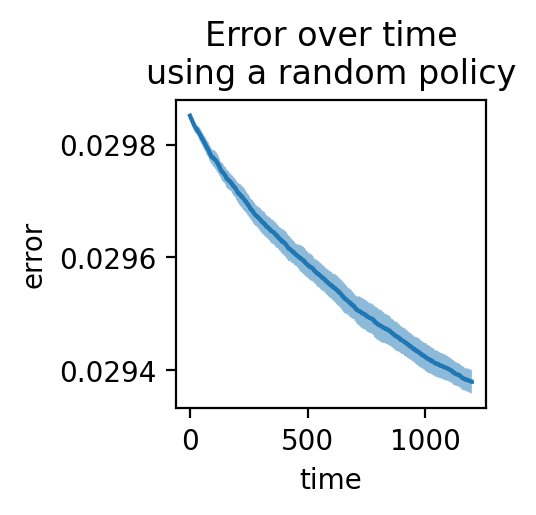

In [83]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(hist_err.mean(axis=0))
ax.fill_between(np.arange(n_episode*n_timestep),
                hist_err.mean(axis=0) - hist_err.std(axis=0),
                hist_err.mean(axis=0) + hist_err.std(axis=0),
                alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("error")
ax.set_title("Error over time\nusing a random policy");

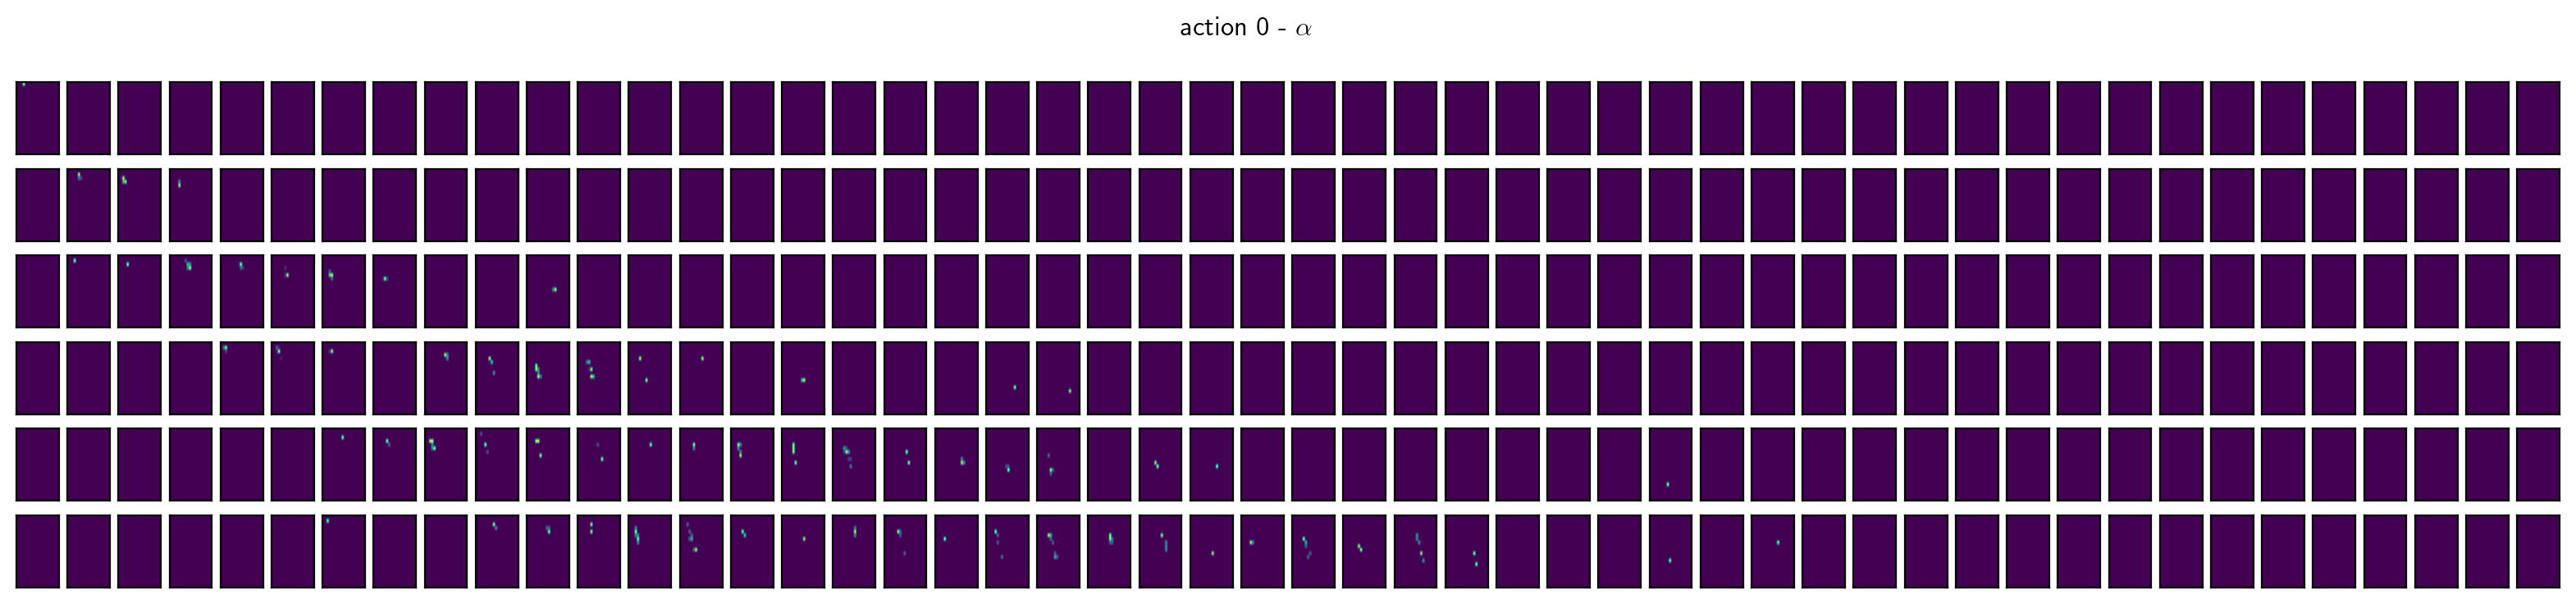

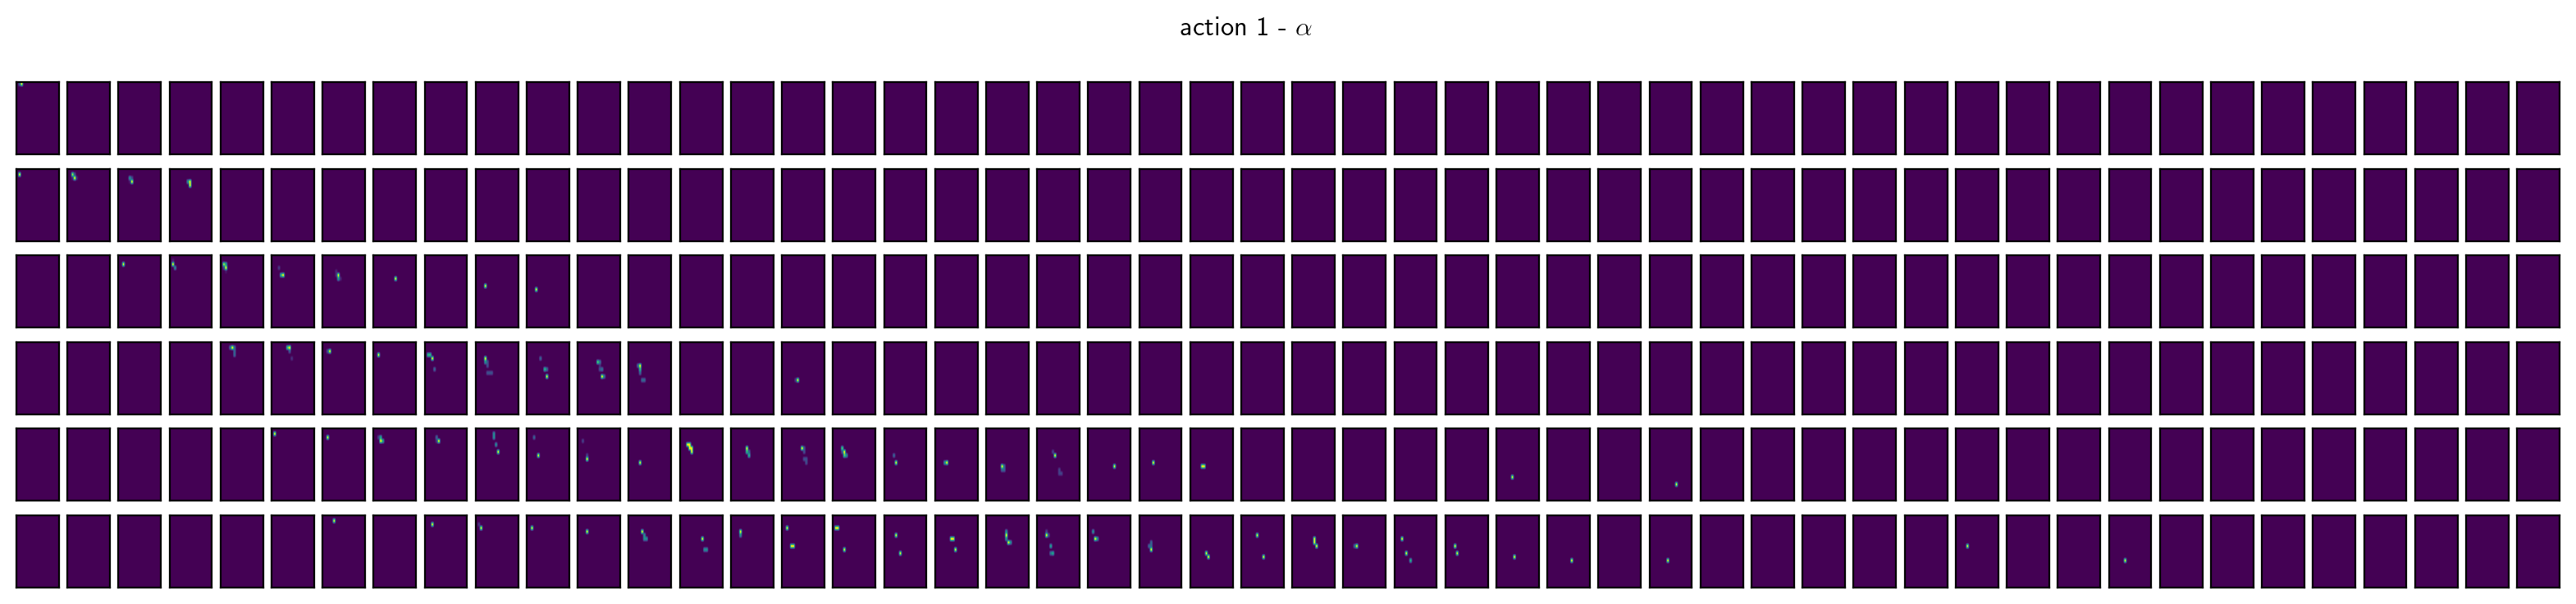

In [84]:
plt.rcParams['text.usetex'] = True
for a_idx in range(2):
    fig, axes = plt.subplots(ncols=n_position, nrows=n_timestep, figsize=(20, 4))
    fig.suptitle(f"action {a_idx} - " + r"$\alpha$")

    for p_idx in range(n_position): 
        for t_idx in range(n_timestep):
            ax = axes[t_idx, p_idx]
            img = alpha_tapvv[t_idx, a_idx, p_idx, :, :]
            ax.imshow(img, aspect="auto")
            ax.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
    
    plt.plot()

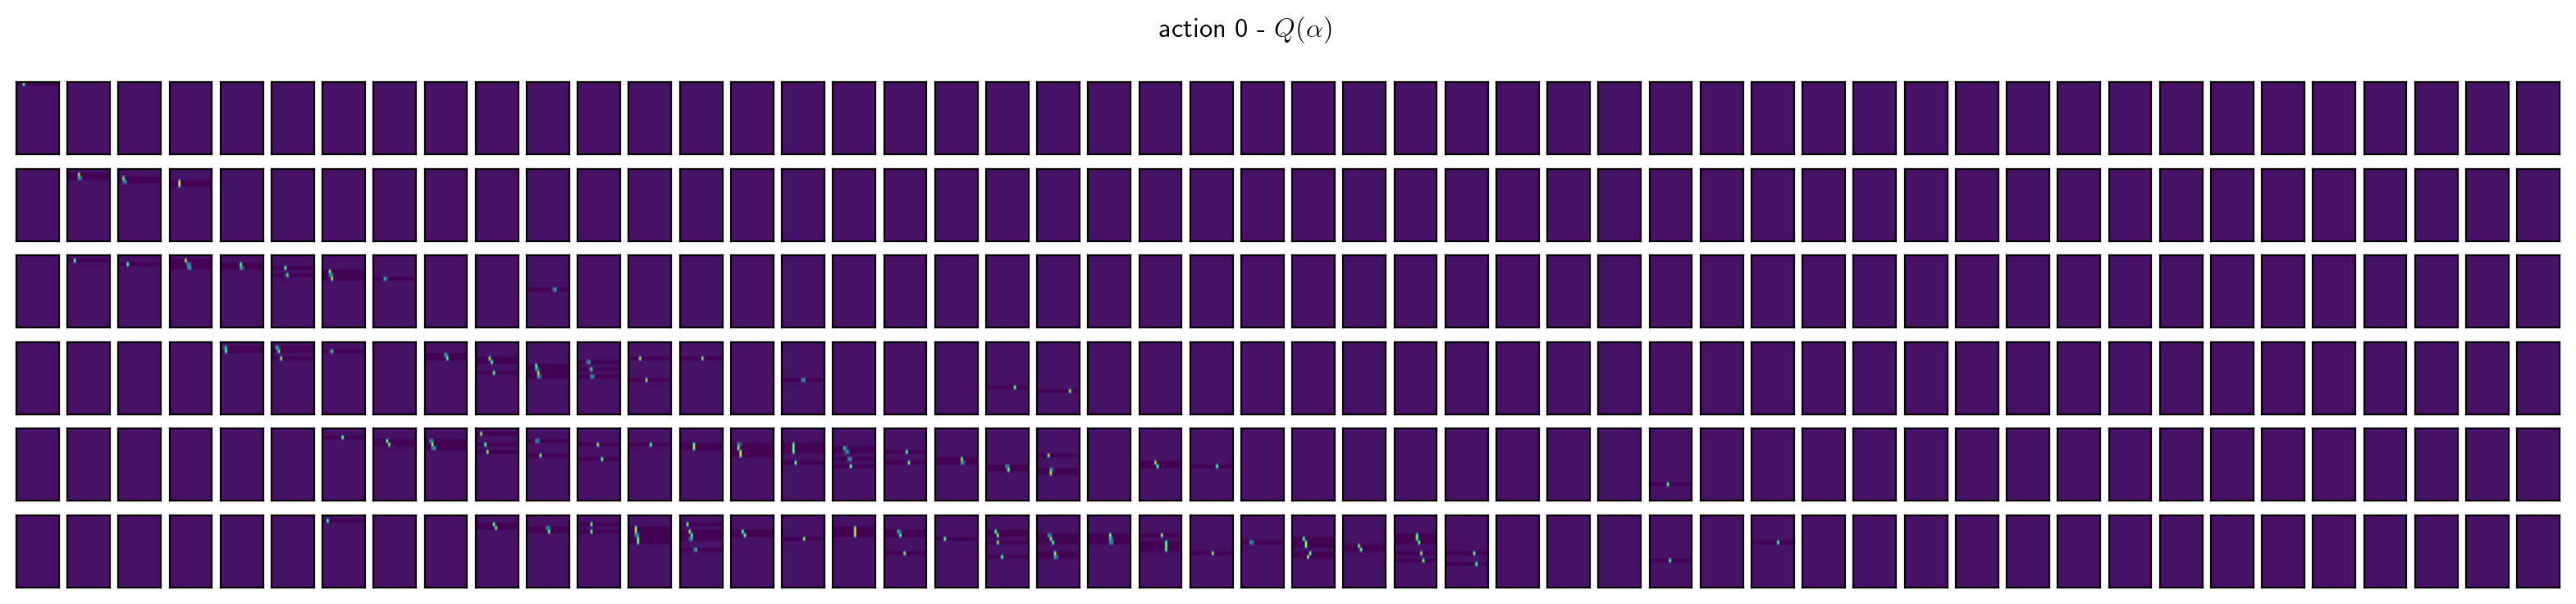

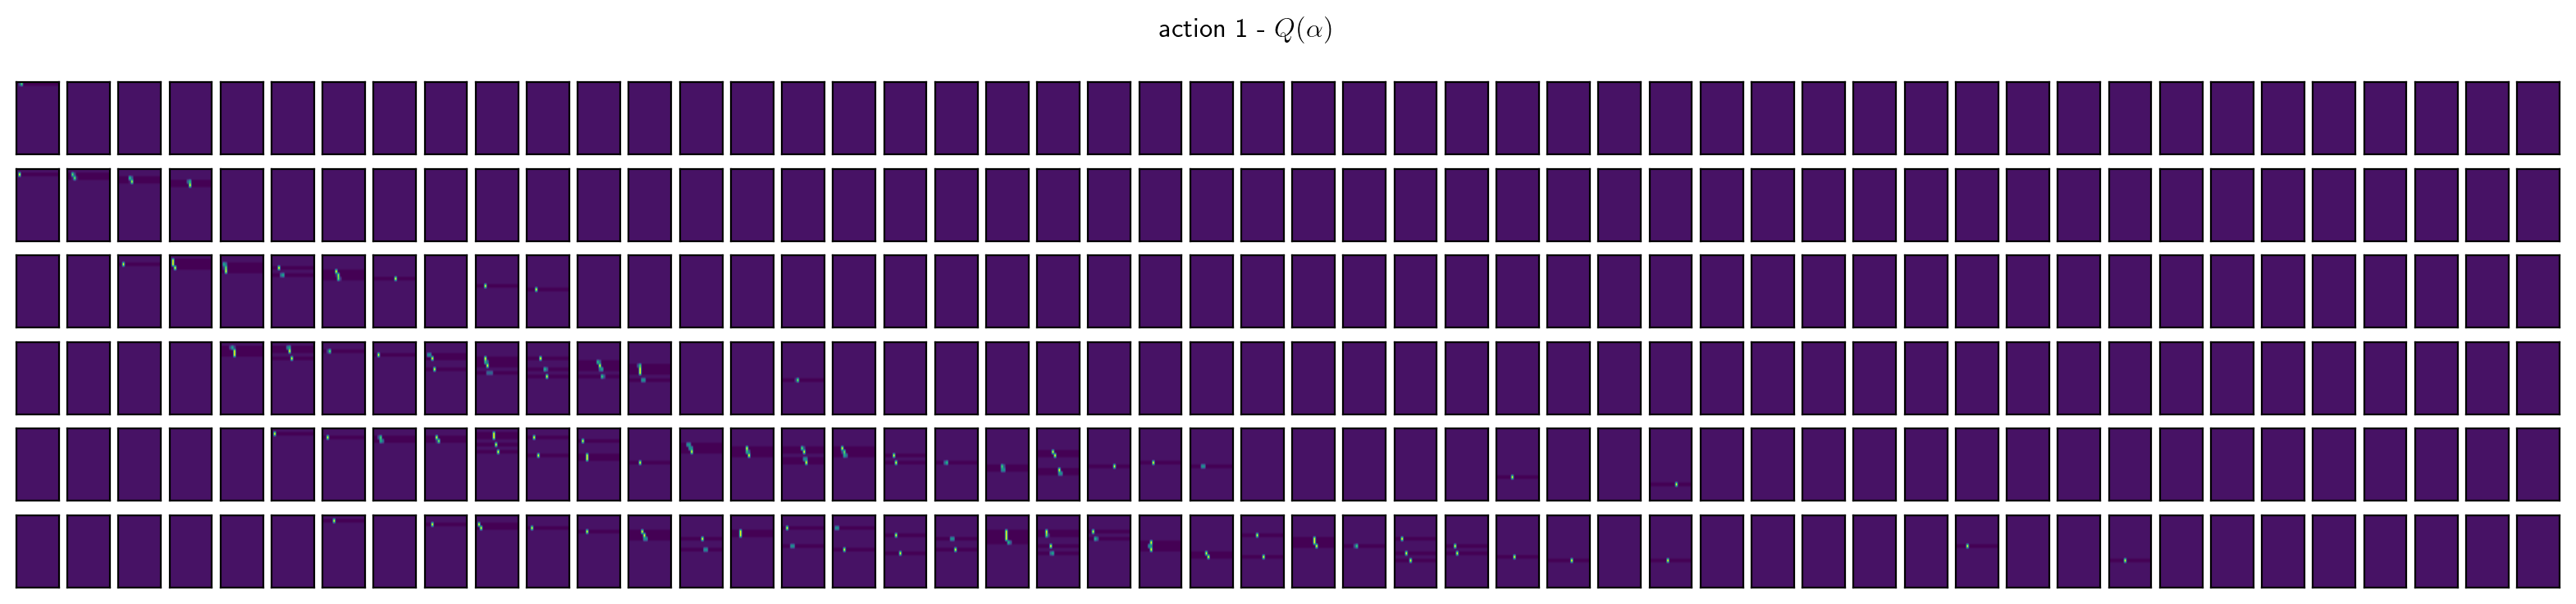

In [85]:
q = q_transition_velocity(alpha_tapvv)

plt.rcParams['text.usetex'] = True
for a_idx in range(2):
    fig, axes = plt.subplots(ncols=n_position, nrows=n_timestep, figsize=(20, 4))
    fig.suptitle(f"action {a_idx} - " + r"$Q(\alpha)$")

    for p_idx in range(n_position): 
        for t_idx in range(n_timestep):

            ax = axes[t_idx, p_idx]
            img = q[t_idx, a_idx, p_idx, :, :]
            ax.imshow(img, aspect="auto", vmin=0, vmax=1)
            ax.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
    plt.plot()

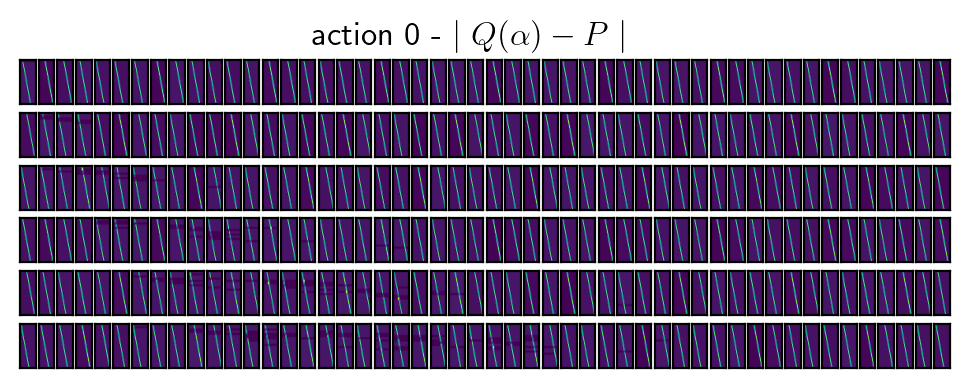

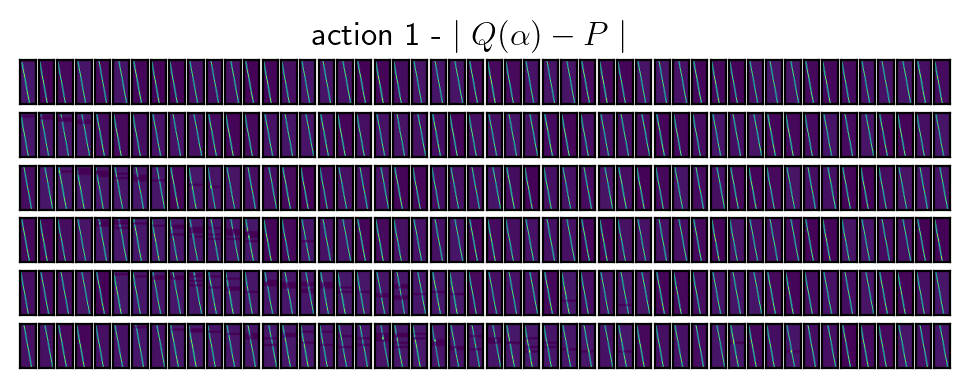

In [86]:
q = q_transition_velocity(alpha_tapvv)
diff = np.absolute(transition_velocity_tapvv - q)

plt.rcParams['text.usetex'] = True
for a_idx in range(2):
    fig, axes = plt.subplots(ncols=n_position, nrows=n_timestep,figsize=(6, 2))
    fig.suptitle(f"action {a_idx} - " + r"$\mid Q(\alpha) - P \mid$")

    for p_idx in range(n_position):
        for t_idx in range(n_timestep):
            ax = axes[t_idx, p_idx]
            img = diff[t_idx, a_idx, p_idx, :, :]
            ax.imshow(img, aspect="auto")
            ax.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])

    plt.show()

In [89]:
from task import run_epistemic
n_sample = 10
n_episode = 200
with tqdm(total=n_episode*n_timestep*n_sample) as pbar:
    hist_err = run_epistemic.run_task(
        pbar=pbar,
        horizon=n_timestep,
        position=position, velocity=velocity, timestep=timestep,
        transition_velocity_tapvv=transition_velocity_tapvv, 
        transition_position_pvp=transition_position_pvp, 
        n_episode=n_episode, n_sample=n_sample)

policy = "af-epistemic"
if policy not in policies_err:
    policies_err.append(policy)
all_hist_err[policy] = hist_err

  6%|▋         | 754/12000 [00:15<02:59, 62.57it/s]Process SpawnPoolWorker-68:
Process SpawnPoolWorker-61:
Process SpawnPoolWorker-64:
Process SpawnPoolWorker-65:
Process SpawnPoolWorker-67:
Process SpawnPoolWorker-70:
Process SpawnPoolWorker-66:
Process SpawnPoolWorker-69:
Process SpawnPoolWorker-62:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/aureliennioche/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/aureliennioche/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/aureliennioche/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/aureliennioche/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._k

Initial error 0.03


KeyboardInterrupt: 

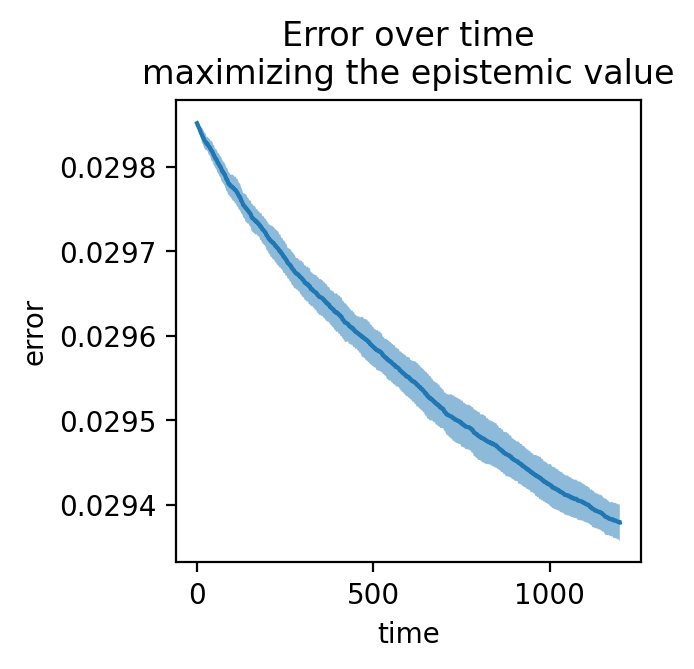

In [87]:
plt.rcParams['text.usetex'] = False
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(hist_err.mean(axis=0))
ax.fill_between(np.arange(len(hist_err.mean(axis=0))), hist_err.mean(axis=0) - hist_err.std(axis=0), hist_err.mean(axis=0) + hist_err.std(axis=0), alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("error")
ax.set_title("Error over time\nmaximizing the epistemic value");

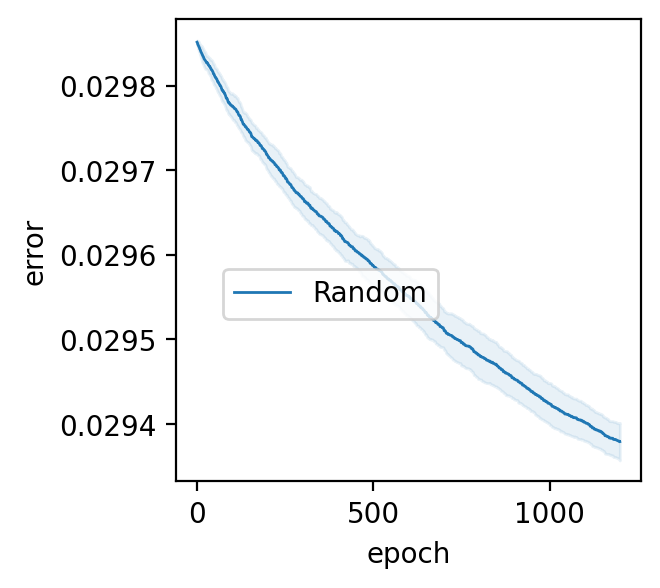

In [88]:
fig, ax = plt.subplots(figsize=(3, 3))
for i, policy in enumerate(policies_err):
    label = policy.replace("-", " ").capitalize()
    hist_err_mean = all_hist_err[policy].mean(axis=0)
    x = np.arange(len(hist_err_mean))
    hist_err_std = all_hist_err[policy].std(axis=0)

    if label.startswith("Af"):
        label = label.replace("Af", "Active inference -")
        linestyle, linewidth = "-", 2
    else:
        linestyle, linewidth = "-", 1
    ax.plot(x, hist_err_mean, color=f"C{i}", label=label, linestyle=linestyle, linewidth=linewidth)
    ax.fill_between(x, hist_err_mean - hist_err_std, hist_err_mean + hist_err_std, alpha=0.1, color=f"C{i}")
    ax.set_ylabel("error")
    ax.set_xlabel("epoch")

fig.legend(loc="center");

# All together

In [59]:
n_episode = 400
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))
hist_pos = np.zeros((n_sample_run, n_episode, n_timestep))
hist_vel = np.zeros((n_sample_run, n_episode, n_timestep))

for sample in range(n_sample_run):

    alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).tiny + 0.01

    error = np.sum(np.absolute(transition_velocity_tavv - q_transition_velocity(alpha_tavv)))
    if sample == 0:
        print(f"Initial error {error:.2f}")

    hist_a = []
    epoch = 0

    with tqdm(total=n_episode) as pbar:
        for ep_idx in range(n_episode):

            np.random.seed(12334 + ep_idx + sample * 123)

            pos_idx = np.absolute(position).argmin()  # Something close to 0
            v_idx = np.absolute(velocity).argmin() # Something close to 0

            for t_idx, t in enumerate(timestep):

                h = min(horizon, n_timestep - t_idx)
                action_plan = list(itertools.product(range(n_action), repeat=h))
                n_action_plan = len(action_plan)

                # Initialize action plan values
                pragmatic = np.zeros(n_action_plan)
                epistemic = np.zeros(n_action_plan)

                q = q_transition_velocity(alpha_tavv)

                # Compute value of each action plan
                for ap_index, ap in enumerate(action_plan):

                    # Initialize the rollout model
                    alpha_tavv_rollout = alpha_tavv.copy()
                    qv = np.zeros(n_velocity)
                    qv[v_idx] = 1.
                    qps = np.zeros((h, n_position))
                    qp = np.zeros(n_position)
                    qp[pos_idx] = 1.

                    for h_idx, a in enumerate(ap):

                        # Update rollout time index
                        rollout_t_index = t_idx + h_idx

                        # Update beliefs about the transition model
                        alpha_tavv_rollout[rollout_t_index,  a, :, :] += qv[:, np.newaxis] * q[rollout_t_index, a, :, :]

                        # Update beliefs about the velocity and position [IMPORTANT: doing this after updating the transition model]
                        qv = qv @ q[rollout_t_index, a, :, :]
                        qp = qp @ (qv @ transition_position_pvp)
                        qps[h_idx] = qp

                    # Compute the pragmatic value of the action plan
                    pragmatic[ap_index] = np.sum(qps @ log_prior)

                    # Compute the KL divergence between the model after the rollout and the current model
                    epistemic[ap_index] = kl_div_dirichlet(alpha_tavv_rollout, alpha_tavv)

                val = pragmatic + epistemic
                best_action_plan_indexes = np.arange(n_action_plan)[val == val.max()]
                selected_action_plan_idx = np.random.choice(best_action_plan_indexes)
                a = action_plan[selected_action_plan_idx][0]

                new_v_index = np.random.choice(n_velocity, p=transition_velocity_tavv[t_idx, a, v_idx, :])

                # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
                alpha_tavv[t_idx, a, v_idx, new_v_index] += 1

                # Update velocity and position
                v_idx = new_v_index
                pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])

                # Log
                error = np.sum(np.absolute(transition_velocity_tavv - q_transition_velocity(alpha_tavv)))
                hist_err[sample, epoch] = error
                hist_pos[sample, ep_idx, t_idx] = position[pos_idx]
                hist_vel[sample, ep_idx, t_idx] = velocity[v_idx]
                hist_a.append(a)
                epoch += 1

            pbar.set_description(f"[Sample {sample}] [Episode {ep_idx}]")
            pbar.set_postfix(error=f"{error:.2f}", position=f"{position[pos_idx]:.2f}")
            pbar.update(1)

        print(f"[Sample {sample}] Error after {epoch} epochs: {error:.2f}")
        print(f"[Sample {sample}] Freq choose action 0: {100*hist_a.count(0)/len(hist_a):.2f}%")

policy = "af"
if policy not in policies:
    policies.append(policy)
if policy not in policies_err:
    policies_err.append(policy)
all_hist_err[policy] = hist_err
all_hist_pos[policy] = hist_pos[:, -1, :] # Keep only the last episode
all_hist_vel[policy] = hist_vel[:, -1, :] # Keep only the last episode

NameError: name 'transition_velocity_tavv' is not defined

In [ ]:
plot_runs(policies, all_hist_pos, all_hist_vel)

# Possible extensions

    - Always using a fix horizon (modulo the beginning of the episode)
    - Pretraining the model
    - Using a couple of different generative models
    - Add meaninful priors (e.g. night)
    - Add the current position as a predictor of the velocity

In [ ]:
    # # ---- Pre-training ----
    #
    # epoch = 0
    # for idx_ep in tqdm(range(n_episode_pre_train)):
    #
    #     np.random.seed(12334 + idx_ep)
    #
    #     pos_idx = np.absolute(position).argmin()  # Something close to 0
    #     v_idx = np.absolute(velocity).argmin() # Something close to 0
    #
    #     action_plan = np.random.randint(n_action, size=n_timestep)
    #
    #     for ap_index in range(len(action_plan)):
    #
    #         a = action_plan[t_idx]
    #         new_v_index = np.random.choice(np.arange(n_velocity), p=transition_velocity_tvav[t_idx, v_idx, a, :])
    #
    #         # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
    #         alpha_tvav[t_idx, v_idx, a, new_v_index] += 1
    #
    #         # print("v_idx", v_idx, "new_v_index", new_v_index)
    #
    #         # Update velocity and position
    #         v_idx = new_v_index
    #         pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])
    #
    #         # Log
    #         error = np.sum(np.absolute(transition_velocity_tvav - q_transition_velocity(alpha_tvav)))
    #         hist_err.append(error)
    #         epoch += 1

    # print(f"Error after {epoch} epochs, before learning: {error}")